# Traffic Situation Classification Using Real-Time Vehicle Count Data

### Objective:
To build a machine learning model that predicts traffic conditions (Low, Normal, High, Heavy) based on real-time vehicle counts and time-based features.

This project involves:
- Cleaning and preprocessing raw traffic data
- Engineering features like time in minutes and day encoding
- Exploring trends and traffic patterns
- Training and evaluating classification models
- Interpreting feature importance to understand key traffic drivers

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np

## Load and Explore of the Data

In [2]:
# load the csv
data = pd.read_csv("../data/TrafficDataset.csv")

In [3]:
data.tail()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
2971,10:45:00 PM,09-11-2023,Thursday,6,0,2,34,42,normal
2972,11:00:00 PM,09-11-2023,Thursday,5,0,2,24,31,normal
2973,11:15:00 PM,09-11-2023,Thursday,11,2,2,32,47,normal
2974,11:30:00 PM,09-11-2023,Thursday,5,2,2,37,46,normal
2975,11:45:00 PM,09-11-2023,Thursday,10,1,0,25,36,normal


In [4]:
data.describe()

,CarCount,BikeCount,BusCount,TruckCount,Total
count,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000
mean,62.184812,9.405578,10.546371,21.967742,104.104503
std,43.384148,9.275747,9.774527,10.312510,50.972085
min,5.000000,0.000000,0.000000,5.000000,25.000000
25%,15.000000,2.000000,2.000000,13.000000,53.000000
50%,61.000000,7.000000,8.000000,21.000000,101.000000
75%,97.000000,15.000000,17.000000,30.000000,144.000000
max,150.000000,50.000000,40.000000,60.000000,227.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               2976 non-null   object
 1   Date               2976 non-null   object
 2   Day of the week    2976 non-null   object
 3   CarCount           2976 non-null   int64 
 4   BikeCount          2976 non-null   int64 
 5   BusCount           2976 non-null   int64 
 6   TruckCount         2976 non-null   int64 
 7   Total              2976 non-null   int64 
 8   Traffic Situation  2976 non-null   object
dtypes: int64(5), object(4)
memory usage: 209.4+ KB


In [6]:
data.dtypes
# Date, Time, Day of the week is object, need to convert to correct dtypes

Time                 object
Date                 object
Day of the week      object
CarCount              int64
BikeCount             int64
BusCount              int64
TruckCount            int64
Total                 int64
Traffic Situation    object
dtype: object

In [7]:
data.isnull().sum()
# no missing values

Time                 0
Date                 0
Day of the week      0
CarCount             0
BikeCount            0
BusCount             0
TruckCount           0
Total                0
Traffic Situation    0
dtype: int64

In [8]:
#check values in the column
data[data['Traffic Situation'] == "heavy"]

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
31,7:45:00 AM,10-10-2023,Tuesday,143,30,17,12,202,heavy
32,8:00:00 AM,10-10-2023,Tuesday,134,18,21,11,184,heavy
33,8:15:00 AM,10-10-2023,Tuesday,134,30,15,14,193,heavy
35,8:45:00 AM,10-10-2023,Tuesday,139,12,22,13,186,heavy
63,3:45:00 PM,10-10-2023,Tuesday,150,21,10,14,195,heavy
...,...,...,...,...,...,...,...,...,...
2948,5:00:00 PM,09-11-2023,Thursday,132,16,13,11,172,heavy
2949,5:15:00 PM,09-11-2023,Thursday,115,26,34,20,195,heavy
2950,5:30:00 PM,09-11-2023,Thursday,105,16,32,17,170,heavy
2952,6:00:00 PM,09-11-2023,Thursday,147,22,17,20,206,heavy


We begin by loading the dataset and reviewing its structure.

- Total records: 2,976
- Time granularity: ~96 entries per day (15-minute intervals)
- No missing data
- Traffic is categorized into 4 levels:
  - Low
  - Normal
  - High
  - Heavy

We also examine the data types and confirm that date/time fields need conversion for further analysis.


## Time Feature Engineering

We create a new numeric feature `TimeInMins` representing the number of minutes past midnight for each timestamp in the `Time` column. This transformation is useful for plotting time-based trends and for feeding numerical values into machine learning models.

Example:  
- `"12:00:00 AM"` → `0`  
- `"01:30:00 PM"` → `13 * 60 + 30 = 810`


In [9]:
df = data.copy()

In [10]:
#Convert time to mins
dt = pd.to_datetime(data['Time'],format='%I:%M:%S %p')
df['TimeInMins'] = dt.apply(lambda t: t.hour * 60 + t.minute)

In [11]:
df['Date'].head()

0    10-10-2023
1    10-10-2023
2    10-10-2023
3    10-10-2023
4    10-10-2023
Name: Date, dtype: object

In [12]:
# Date Conversion
df['Date'] = pd.to_datetime(df['Date'], format = "%d-%m-%Y", errors='coerce')
df['Date'].unique()

<DatetimeArray>
['2023-10-10 00:00:00', '2023-10-11 00:00:00', '2023-10-12 00:00:00',
 '2023-10-13 00:00:00', '2023-10-14 00:00:00', '2023-10-15 00:00:00',
 '2023-10-16 00:00:00', '2023-10-17 00:00:00', '2023-10-18 00:00:00',
 '2023-10-19 00:00:00', '2023-10-20 00:00:00', '2023-10-21 00:00:00',
 '2023-10-22 00:00:00', '2023-10-23 00:00:00', '2023-10-24 00:00:00',
 '2023-10-25 00:00:00', '2023-10-26 00:00:00', '2023-10-27 00:00:00',
 '2023-10-28 00:00:00', '2023-10-29 00:00:00', '2023-10-30 00:00:00',
 '2023-10-31 00:00:00', '2023-11-01 00:00:00', '2023-11-02 00:00:00',
 '2023-11-03 00:00:00', '2023-11-04 00:00:00', '2023-11-05 00:00:00',
 '2023-11-06 00:00:00', '2023-11-07 00:00:00', '2023-11-08 00:00:00',
 '2023-11-09 00:00:00']
Length: 31, dtype: datetime64[ns]

### Relative Date Feature: `DateFromReference`

We define **2023-10-09** as a reference date and compute how many days each entry is from that date. This gives us a new time-based feature `DateFromReference`, useful for plotting temporal trends or training models with temporal structure.

This transformation simplifies time-series modeling by representing each date as a numeric offset from a fixed point in time.


In [13]:
# make 2023-10-09 as reference date, and calculate
reference_date = pd.Timestamp('2023-10-09')
df['DateFromReference'] = (df['Date'] - reference_date).dt.days
print("First 10:")
print(df['DateFromReference'].head(10))
print("Last 10:")
df['DateFromReference'].tail(10)

First 10:
0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: DateFromReference, dtype: int64
Last 10:


2966    31
2967    31
2968    31
2969    31
2970    31
2971    31
2972    31
2973    31
2974    31
2975    31
Name: DateFromReference, dtype: int64

In [14]:
# Traffic Situation Categories

df['Traffic Situation'].unique()

array(['normal', 'low', 'heavy', 'high'], dtype=object)

### Encoding Categorical Variable: `Traffic Situation`

We convert the `Traffic Situation` column from text labels to numeric values using the following mapping:

- `'low'` → 0  
- `'normal'` → 1  
- `'high'` → 2  
- `'heavy'` → 3

This numeric encoding is essential for training models, especially for classification tasks.


In [15]:
df2 = df.copy()

In [16]:
traffic_map = {
    'low':0,
    'normal':1,
    'high':2,
    'heavy':3
}
df2['Traffic Situation'] = df2['Traffic Situation'].map(traffic_map)

In [17]:
df2['Traffic Situation'].head()

0    1
1    1
2    1
3    1
4    1
Name: Traffic Situation, dtype: int64

In [18]:
 # Cleanup: Dropping Redundant Columns
df3 = df2.copy()
df3 =df3.drop(columns = ['Time', 'Date'])

In [19]:
df3.head(300)

,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation,TimeInMins,DateFromReference
0,Tuesday,13,2,2,24,41,1,0,1
1,Tuesday,14,1,1,36,52,1,15,1
2,Tuesday,10,2,2,32,46,1,30,1
3,Tuesday,10,2,2,36,50,1,45,1
4,Tuesday,11,2,1,34,48,1,60,1
...,...,...,...,...,...,...,...,...,...
295,Friday,5,2,2,36,45,1,105,4
296,Friday,9,0,2,35,46,1,120,4
297,Friday,14,0,0,30,44,1,135,4
298,Friday,5,0,0,29,34,1,150,4


In [20]:
df3.describe()

,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation,TimeInMins,DateFromReference
count,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000
mean,62.184812,9.405578,10.546371,21.967742,104.104503,1.269489,712.500000,16.000000
std,43.384148,9.275747,9.774527,10.312510,50.972085,0.832102,415.739495,8.945775
min,5.000000,0.000000,0.000000,5.000000,25.000000,0.000000,0.000000,1.000000
25%,15.000000,2.000000,2.000000,13.000000,53.000000,1.000000,356.250000,8.000000
50%,61.000000,7.000000,8.000000,21.000000,101.000000,1.000000,712.500000,16.000000
75%,97.000000,15.000000,17.000000,30.000000,144.000000,1.000000,1068.750000,24.000000
max,150.000000,50.000000,40.000000,60.000000,227.000000,3.000000,1425.000000,31.000000


## Exploratory Data Analysis (EDA)

We use visualizations to understand traffic trends and feature relationships.

### Key findings:
- 🚗 **CarCount** is the dominant contributor to total traffic
- 🕐 **Morning and evening peaks** are clearly visible in time-series plots
- 📅 Traffic is fairly consistent across days of the week
- 🚨 `Traffic Situation` is imbalanced — most entries are labeled as "Normal"


### Vehicle Traffic Trends Throughout the Day

This line plot visualizes how the counts of different vehicle types vary over the course of a day, using `TimeInMins` (0 to 1440) on the x-axis.

**Key observations:**
- **Car traffic** shows distinct **rush hour peaks** around 8–9 AM and 5–6 PM.
- **Truck traffic** remains relatively constant throughout the day.
- **Bike and bus counts** show modest variations but follow a similar trend to cars.

This visualization highlights the impact of daily routines on traffic patterns.


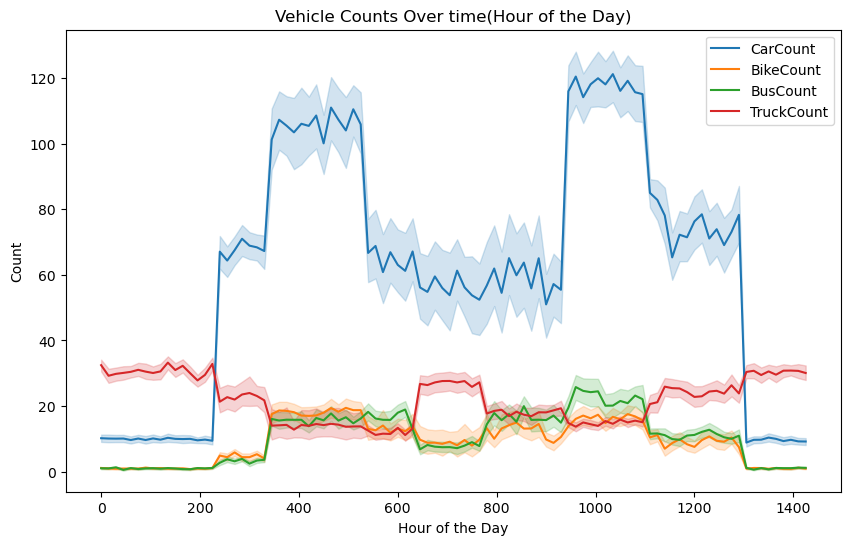

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))
sns.lineplot(data=df3, x=df3['TimeInMins'],y = df3['CarCount'], label ='CarCount')
sns.lineplot(data=df3, x=df3['TimeInMins'],y = df3['BikeCount'], label ='BikeCount')
sns.lineplot(data=df3, x=df3['TimeInMins'],y = df3['BusCount'], label ='BusCount')
sns.lineplot(data=df3, x=df3['TimeInMins'],y = df3['TruckCount'], label ='TruckCount')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.title('Vehicle Counts Over time(Hour of the Day)')
plt.legend()
plt.show()

### Total Vehicle Count by Day of the Week

This boxplot shows how the total number of vehicles varies across different days of the week.

**Insights:**
- Median traffic volume is consistent from Monday to Sunday.
- Weekends (Saturday and Sunday) do not show significantly lower traffic than weekdays, implying steady vehicle flow every day.
- Outliers exist but appear equally across all days, suggesting rare spikes are not day-specific.

This helps confirm that traffic volume is relatively stable throughout the week.


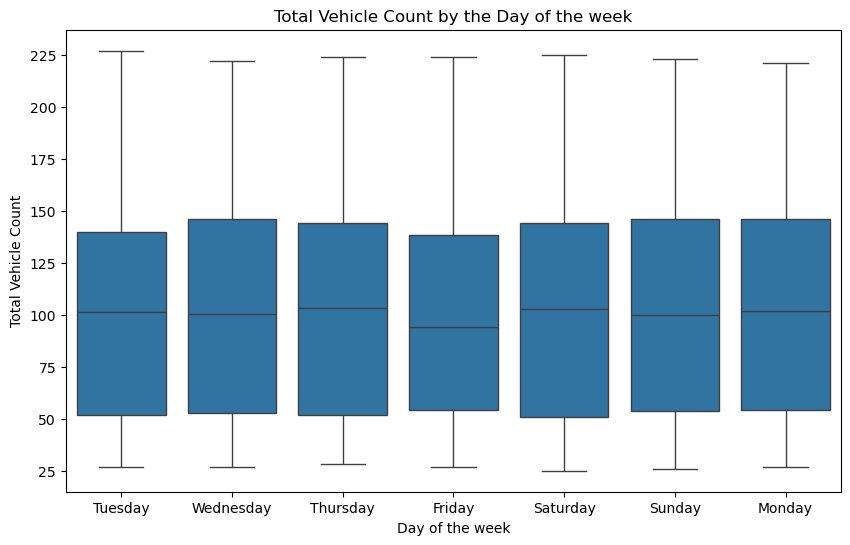

In [22]:
#Total Vehicle Count by the Day of the week
plt.figure(figsize=(10,6))
sns.boxplot(data=df3, x='Day of the week', y='Total')
plt.title('Total Vehicle Count by the Day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Total Vehicle Count')
plt.show()

### Vehicle Type Distribution by Day of the Week

This grouped bar plot shows the total count of each vehicle type for every day of the week.

**Key takeaways:**
- **Cars** dominate traffic volumes by a large margin on all days.
- **Truck traffic** is fairly consistent and high across the week, slightly lower on weekends.
- **Bikes and buses** contribute relatively little but show increased presence midweek.
- Traffic volume peaks midweek (Tuesday–Thursday), and dips slightly on Monday and weekends.

This plot is helpful for urban planning or scheduling road maintenance with minimal disruption.


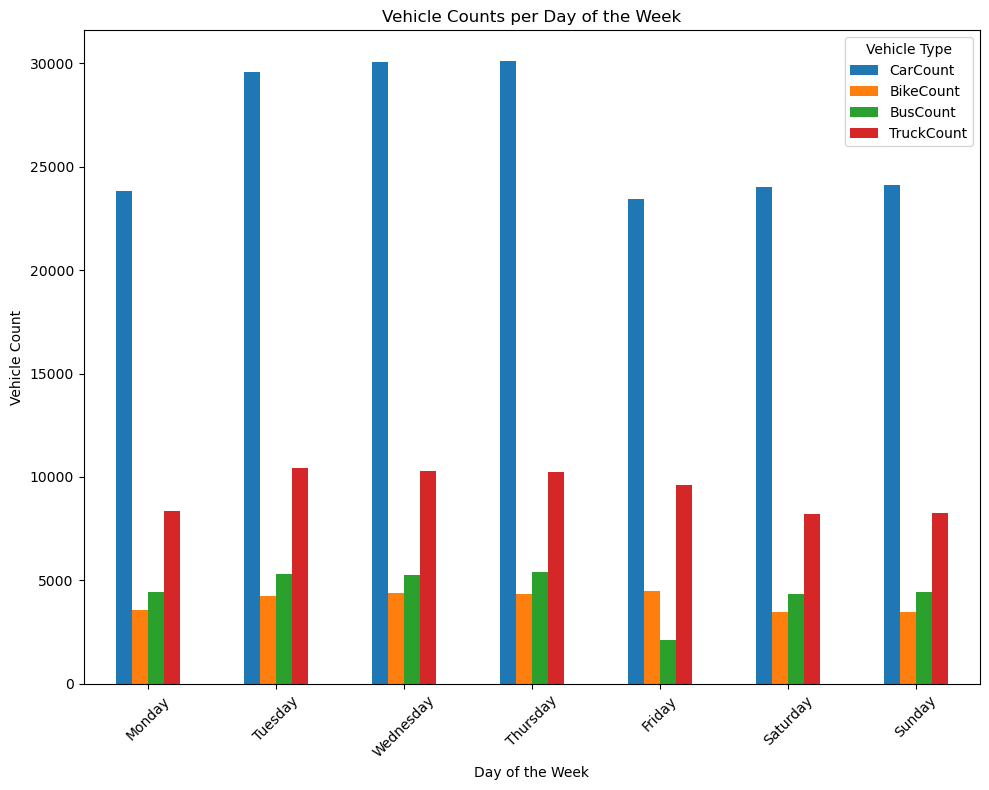

In [23]:
#Vehicle Types and counts by the day of the week

grouped = df3.groupby('Day of the week')[['CarCount','BikeCount','BusCount','TruckCount']].sum()
# Sort days if not already ordered
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
grouped = grouped.reindex(day_order)

grouped.plot(kind='bar',figsize=(10, 8))
plt.title('Vehicle Counts per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Vehicle Count')
plt.xticks(rotation=45)
plt.legend(title='Vehicle Type')
plt.tight_layout()
plt.show()

### Traffic Situation Distribution

This count plot displays the number of samples per traffic class after encoding:

- **0** → Low  
- **1** → Normal  
- **2** → High  
- **3** → Heavy

**Observation:**
- The `normal` class (1) is overwhelmingly dominant.
- `high` traffic situations are rare, which may cause models to underperform on that class.


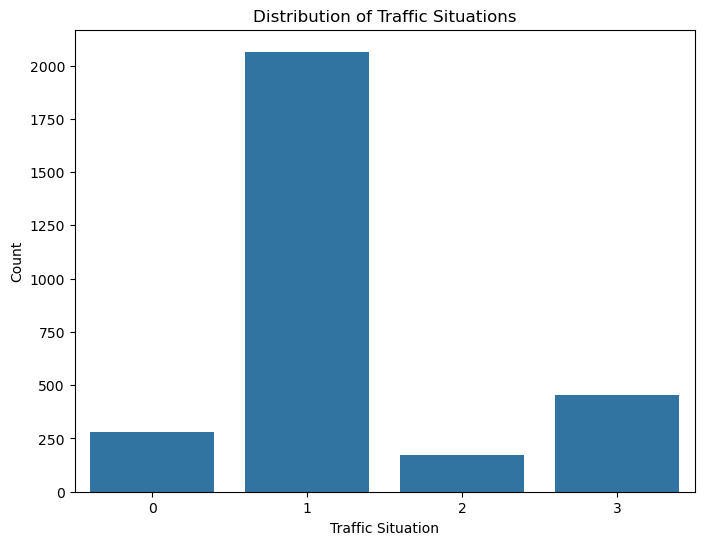

In [24]:
# 4. Traffic Situation Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Traffic Situation', data=df3)
plt.title('Distribution of Traffic Situations')
plt.xlabel('Traffic Situation')
plt.ylabel('Count')
plt.show()

### Pairwise Feature Relationships

We use a pairplot to explore relationships between numerical features and how they relate to the target variable `Traffic Situation`.

**Insights:**
- `CarCount`, `BikeCount`, and `BusCount` show strong positive correlation with `Total` — as expected.
- `Traffic Situation` forms **horizontal bands**, showing class separation along certain axes (e.g., `Total`, `CarCount`), though some overlap exists.
- `TimeInMins` and `TruckCount` don't show strong separation by class, suggesting they may have limited predictive power on their own.

This visualization is useful for assessing feature interactions and data separability, valuable before building classifiers.


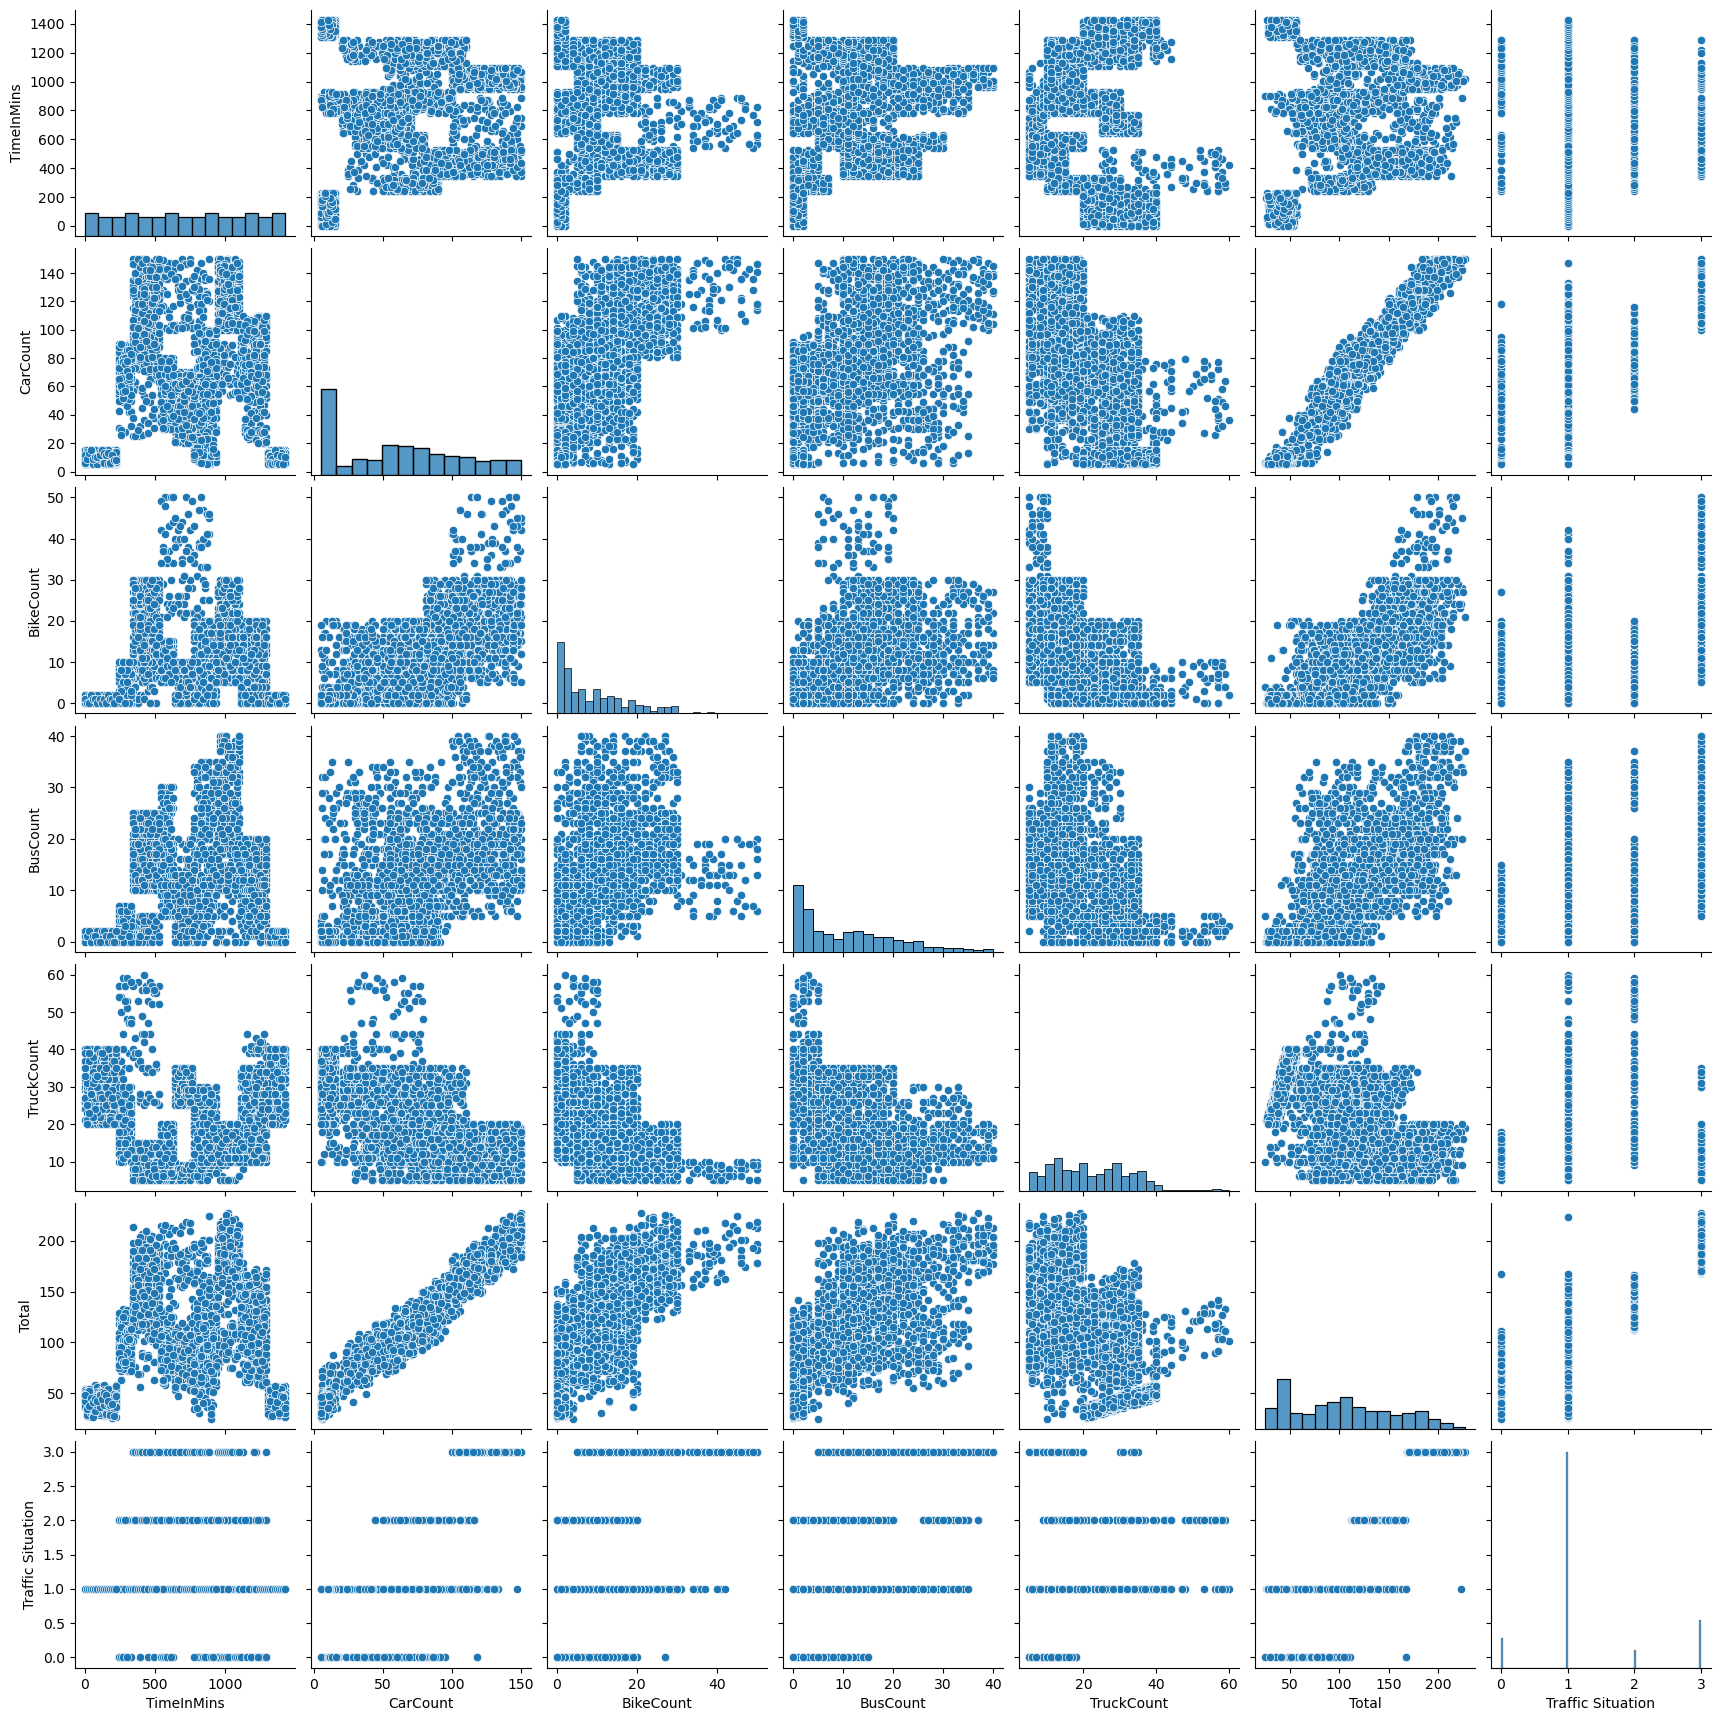

In [25]:
# 5. Pairplot
sns.pairplot(df3[['TimeInMins', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 'Traffic Situation']])
plt.show()

### Time of Day vs. Traffic Situation

This boxplot shows the distribution of `TimeInMins` (minutes since midnight) for each `Traffic Situation` class.

**Insights:**
- **Low traffic (0)** tends to occur early in the morning or late at night.
- **High (2)** and **Heavy (3)** traffic situations are concentrated in the **midday to early evening** period.
- **Normal (1)** traffic spans a broad range, consistent with its class dominance.

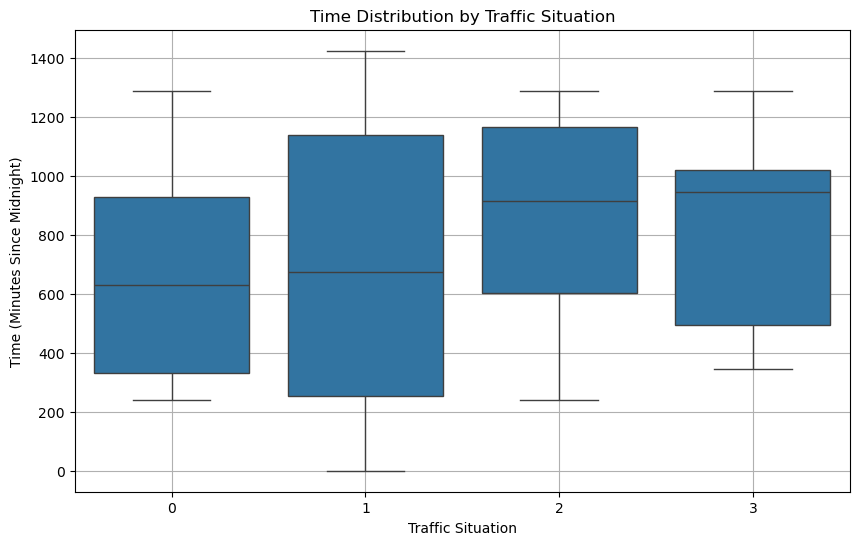

In [28]:
#Time vs Traffic Situation
plt.figure(figsize = (10,6))
sns.boxplot(data= df3, y='TimeInMins', x='Traffic Situation')
plt.title('Time Distribution by Traffic Situation')
plt.xlabel('Traffic Situation')
plt.ylabel('Time (Minutes Since Midnight)')
plt.grid(True)
plt.show()

### Average Traffic Situation by Time of Day

This line plot shows the average `Traffic Situation` score for each minute of the day, giving a smooth view of how traffic intensity changes over time.

**Key patterns:**
- Clear **morning peak** around 6:30 AM to 10 AM.
- Strong **evening peak** between 4 PM and 6 PM, reaching the highest average traffic levels (~2.5).
- Minimal traffic intensity during late night and early morning hours.

This analysis highlights time windows where interventions like congestion pricing or traffic rerouting could be most effective.

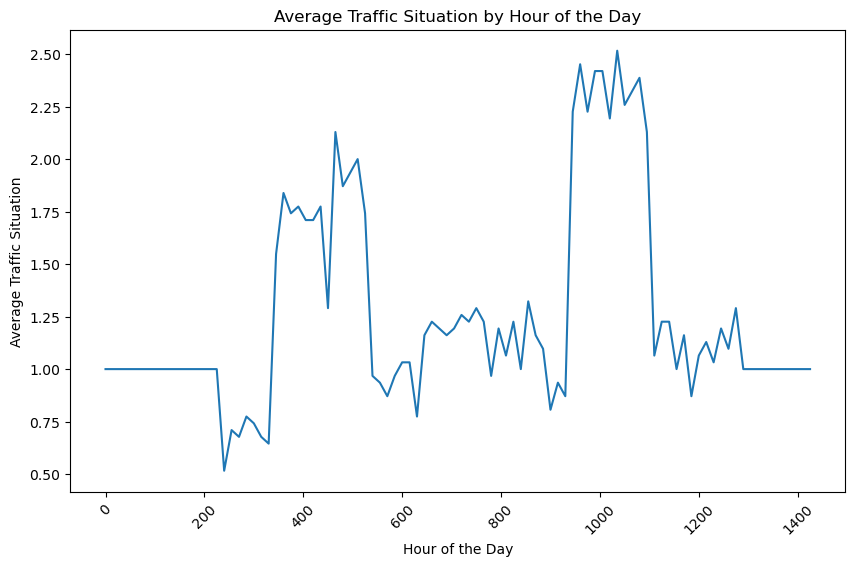

In [29]:
plt.figure(figsize= (10,6))
avg_traffic_by_time = df3.groupby('TimeInMins')['Traffic Situation'].mean()
sns.lineplot(x=avg_traffic_by_time.index, y=avg_traffic_by_time.values)
plt.title('Average Traffic Situation by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Traffic Situation')
plt.xticks(rotation=45)
plt.show()

### 🔗 Correlation Heatmap

We visualize the correlation between all numeric features using a heatmap.

**Key insights:**
- `Total` traffic is almost perfectly correlated with `CarCount` (0.98), indicating cars are the major contributor.
- `Traffic Situation` correlates strongly with:
  - `Total` (0.68)
  - `CarCount` (0.61)
  - `BusCount` and `BikeCount` (moderate positive correlation)
- `TruckCount` shows a **negative correlation** with most features, possibly due to consistent but low-impact volumes.
- Temporal features like `TimeInMins` and `DateFromReference` do not correlate strongly, though they may still capture seasonal effects.

This analysis guides feature selection and helps avoid redundancy in modeling.


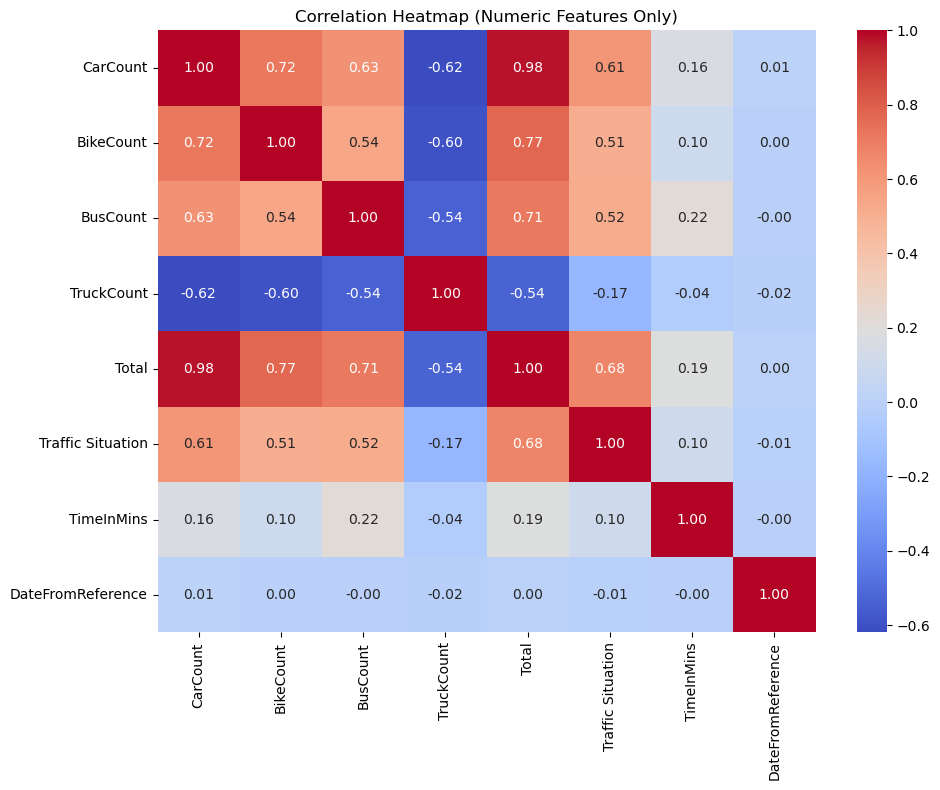

In [30]:
numeric_df = df3.select_dtypes(include='number')

# Step 2: Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Step 3: Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.tight_layout()
plt.show()

## Machine Learning Pipeline

We build a supervised classification model to predict `Traffic Situation` using vehicle counts and time-based features.

### Steps:
1. Feature selection: `CarCount`, `BikeCount`, `BusCount`, `TruckCount`, `TimeInMins`
2. Target: `Traffic Situation` (multi-class)
3. Data split: 80% training, 20% testing
4. Feature scaling using `StandardScaler`
5. Model: `RandomForestClassifier` (baseline)


In [31]:
# MACHINE LEARNING PIPELINE

# Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("Machine Learning libraries imported successfully!")


Machine Learning libraries imported successfully!


## Feature Engineering

We prepare our data for machine learning by encoding categorical variables.

Specifically, we:
- Encoded the `Day of the week` into numeric form using `LabelEncoder`
- Added this as a new feature: `Day_Encoded`

**Day encoding:**
- Friday: 0
- Monday: 1
- Saturday: 2
- Sunday: 3
- Thursday: 4
- Tuesday: 5
- Wednesday: 6

This encoding allows us to include weekday information in models that require numerical inputs.


In [35]:
# 1. FEATURE ENGINEERING

# Create a copy of the processed data for ML
df4 = df3.copy()

# Encode categorical variables - Day of the week
le_day = LabelEncoder()
df4['Day_Encoded'] = le_day.fit_transform(df4['Day of the week'])

# Show the encoding mapping
day_mapping = dict(zip(le_day.classes_, le_day.transform(le_day.classes_)))
print("Day of week encoding:")
for day, code in day_mapping.items():
    print(f"{day}: {code}")

print("\nDataset shape:", df4.shape)
print("\nFirst few rows of processed data:")
df4.head()

Day of week encoding:
Friday: 0
Monday: 1
Saturday: 2
Sunday: 3
Thursday: 4
Tuesday: 5
Wednesday: 6

Dataset shape: (2976, 10)

First few rows of processed data:


,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation,TimeInMins,DateFromReference,Day_Encoded
0,Tuesday,13,2,2,24,41,1,0,1,5
1,Tuesday,14,1,1,36,52,1,15,1,5
2,Tuesday,10,2,2,32,46,1,30,1,5
3,Tuesday,10,2,2,36,50,1,45,1,5
4,Tuesday,11,2,1,34,48,1,60,1,5


In [36]:
df4 = df4.drop(columns= ['Day of the week', 'Total'])

In [37]:
df4.head()

,CarCount,BikeCount,BusCount,TruckCount,Traffic Situation,TimeInMins,DateFromReference,Day_Encoded
0,13,2,2,24,1,0,1,5
1,14,1,1,36,1,15,1,5
2,10,2,2,32,1,30,1,5
3,10,2,2,36,1,45,1,5
4,11,2,1,34,1,60,1,5


### Final Correlation Matrix (Post-Cleanup)

We compute the correlation matrix after dropping redundant columns. This helps us validate that:
- There is no remaining multicollinearity (e.g., from the `Total` column).
- Our features are informative but not overly redundant.

**Highlights:**
- `CarCount`, `BusCount`, and `BikeCount` have the strongest positive relationships with `Traffic Situation`.
- `TruckCount` is negatively correlated with most traffic indicators, suggesting it may play a unique role in classification.
- `TimeInMins` and `Day_Encoded` offer temporal context with minimal correlation, which may still help models capture time-related traffic patterns.

This cleaned feature set is now ready for modeling.


In [38]:
df4.corr()

,CarCount,BikeCount,BusCount,TruckCount,Traffic Situation,TimeInMins,DateFromReference,Day_Encoded
CarCount,1.000000,0.715423,0.626003,-0.619319,0.608690,1.605165e-01,7.463980e-03,6.251858e-03
BikeCount,0.715423,1.000000,0.542872,-0.598063,0.510655,9.918064e-02,2.146950e-04,-6.383547e-02
BusCount,0.626003,0.542872,1.000000,-0.538411,0.515390,2.201465e-01,-4.032504e-03,1.045204e-01
TruckCount,-0.619319,-0.598063,-0.538411,1.000000,-0.171185,-3.826098e-02,-1.669862e-02,-7.149461e-02
Traffic Situation,0.608690,0.510655,0.515390,-0.171185,1.000000,1.040650e-01,-6.276730e-03,-2.963151e-02
TimeInMins,0.160516,0.099181,0.220147,-0.038261,0.104065,1.000000e+00,-6.462596e-16,1.016689e-16
DateFromReference,0.007464,0.000215,-0.004033,-0.016699,-0.006277,-6.462596e-16,1.000000e+00,5.391639e-03
Day_Encoded,0.006252,-0.063835,0.104520,-0.071495,-0.029632,1.016689e-16,5.391639e-03,1.000000e+00


## Feature Selection and Train/Test Split

We select the following features for training:
- `CarCount`
- `BikeCount`
- `BusCount`
- `TruckCount`
- `TimeInMins`

The target variable is:
- `Traffic Situation` (encoded as 0 = low, ..., 3 = heavy)

We split the dataset into training and testing sets using an 80/20 ratio to evaluate model generalization.


In [39]:
# Select features and target

ml_df = df4.copy()
X = ml_df[['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'TimeInMins']]
y = ml_df['Traffic Situation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [40]:
from sklearn.preprocessing import StandardScaler

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)
print("\nFeature scaling applied ✓")

Training set shape: (2380, 5)
Test set shape: (596, 5)

Feature scaling applied ✓


### Model Training: Random Forest Classifier

We train a `RandomForestClassifier` with 100 trees on the scaled feature set.

Random Forest is a powerful ensemble model that:
- Handles both linear and non-linear relationships well
- Is robust to overfitting (especially with many trees)
- Requires minimal preprocessing (but still benefits from clean features)

The model is now trained and ready for prediction and evaluation.


In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf_model= RandomForestClassifier(
    n_estimators = 100, 
    random_state=42, 
    n_jobs =1
)

rf_model.fit(X_train_scaled, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [42]:
y_pred = rf_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy is: {accuracy: .4f}")


Accuracy is:  0.9681


## Model Evaluation: Accuracy Score

We use the trained Random Forest model to predict traffic situations on the test set.

**Accuracy:** 96.81%

This is a strong initial result, but due to class imbalance in the dataset, accuracy alone is not a sufficient metric. We’ll follow up with a classification report and confusion matrix to get a more detailed view of model performance.


In [43]:
# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['Low', 'Normal', 'High', 'Heavy']))


Classification Report:
              precision    recall  f1-score   support

         Low       0.95      1.00      0.97        53
      Normal       0.98      0.97      0.98       418
        High       0.89      0.87      0.88        39
       Heavy       0.94      0.97      0.95        86

    accuracy                           0.97       596
   macro avg       0.94      0.95      0.95       596
weighted avg       0.97      0.97      0.97       596



### Classification Report

We evaluate the Random Forest model using precision, recall, and F1-score for each traffic class.

**Highlights:**
- High performance across all classes, even the minority ones.
- F1-score for each class:
  - Low: 0.97
  - Normal: 0.96
  - High: 0.88
  - Heavy: 0.95
- Weighted average F1-score: **0.96**

This confirms that the model generalizes well and handles imbalanced data effectively a great baseline performance!


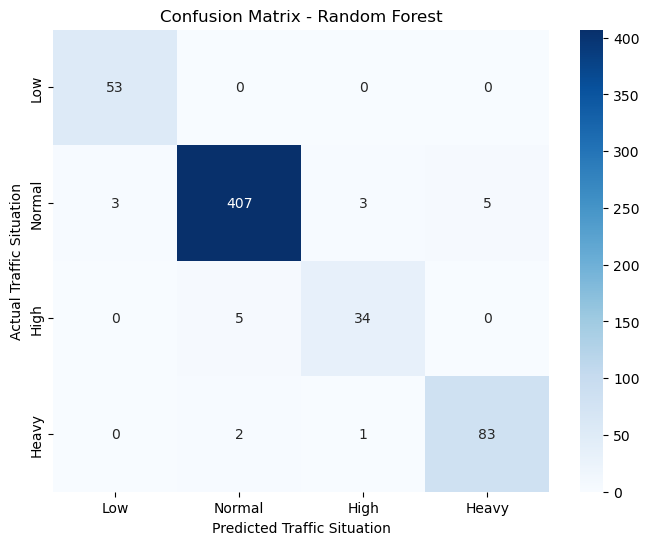

In [44]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low', 'Normal', 'High', 'Heavy'],
            yticklabels=['Low', 'Normal', 'High', 'Heavy'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual Traffic Situation')
plt.xlabel('Predicted Traffic Situation')
plt.show()

### Confusion Matrix - Random Forest

The confusion matrix shows the performance of our model in terms of actual vs. predicted traffic situations.

**Key observations:**
- `Low` traffic is perfectly classified (100% correct).
- Most misclassifications happen within adjacent classes e.g., some `High` labeled as `Normal`, which is reasonable.
- Very few false positives overall, and class imbalance is handled well.

This matrix visually confirms the strength and reliability of the Random Forest model for multi-class traffic classification.


In [45]:
print("Diagonal values (correct predictions):", cm.diagonal())
print("Total misclassifications:", cm.sum() - cm.diagonal().sum())

Diagonal values (correct predictions): [ 53 407  34  83]
Total misclassifications: 19


### Model Performance Summary

From the confusion matrix:

- **Correct predictions (per class):**  
  - Low: 53  
  - Normal: 407  
  - High: 34  
  - Heavy: 83

- **Total correct:** 577  
- **Total misclassifications:** 19  
- **Accuracy:** 577 / 596 ≈ 96.8%

This confirms that the model not only achieves high accuracy, but it distributes correct predictions well across all traffic classes.


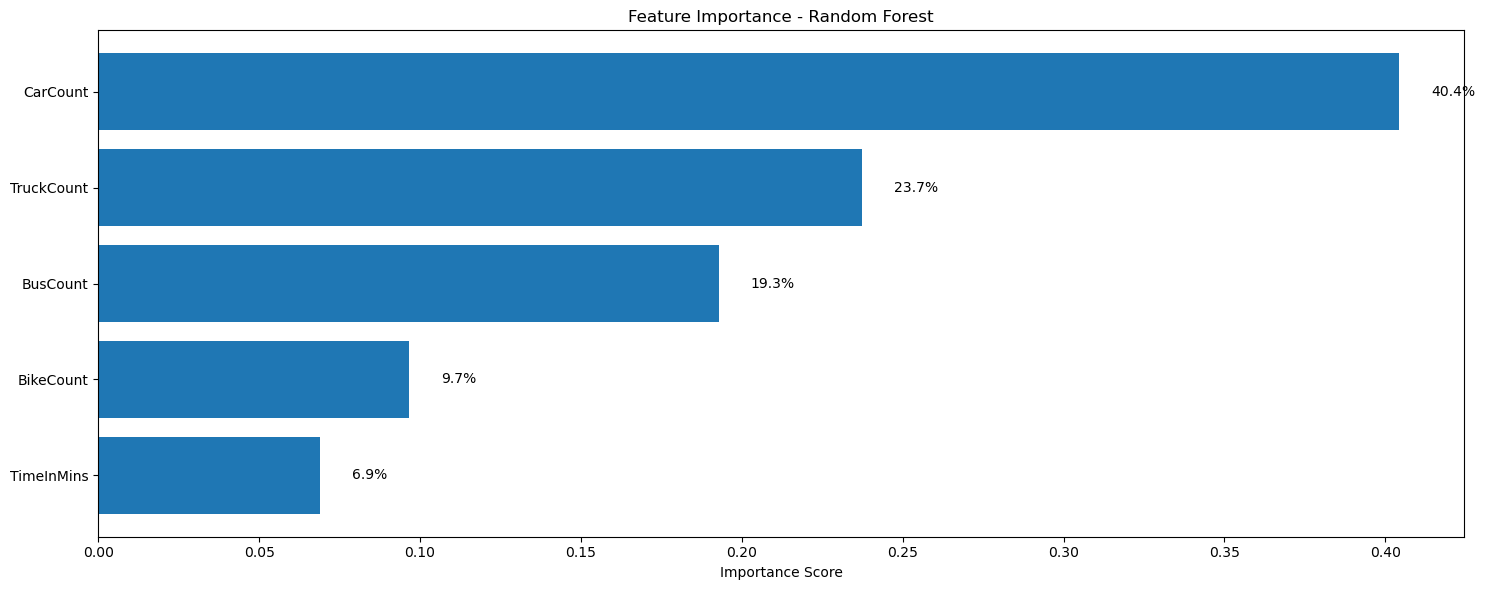


Feature Importance Ranking:
      feature  importance
0    CarCount    0.404218
3  TruckCount    0.237367
2    BusCount    0.192840
1   BikeCount    0.096615
4  TimeInMins    0.068959


In [46]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(15, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importance - Random Forest')
plt.gca().invert_yaxis()  # Highest importance on top

# Add percentage labels
for i, (feature, importance) in enumerate(zip(feature_importance['feature'], 
                                              feature_importance['importance'])):
    plt.text(importance + 0.01, i, f'{importance:.1%}', va='center')

plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
print(feature_importance)

### Feature Importance - Random Forest

We analyze feature importance based on the Random Forest model's internal scoring.

**Top contributors:**
- `CarCount` is by far the most influential feature, contributing ~40% to traffic situation classification.
- `TruckCount` and `BusCount` also play major roles.
- `TimeInMins` has relatively low importance, suggesting vehicle volume is a stronger indicator than time alone.

This confirms that **real-time vehicle type counts** are the primary signals driving traffic condition classification.

## Predict Traffic Situation (Using Trained Model)


We reuse the existing `traffic_map` from preprocessing to decode predictions.  
The `predict_traffic_situation()` function takes new input features and returns the predicted traffic situation.

### Decoding
We reverse the original label-to-int map to convert predicted integers back to human-readable traffic labels.

### Example:
```python
predict_traffic_situation(car=110, bike=6, bus=12, truck=25, time_in_mins=540)
# Output: 'High'


In [47]:
# Reverse the original traffic_map for decoding
reverse_traffic_map = {v: k.capitalize() for k, v in traffic_map.items()}

def predict_traffic_situation(car,bike,bus,truck,time_in_mins):
    """
    Predicts the traffic situation based on input vehicle counts and time.
    Returns a human-readable traffic label using the original traffic_map.
    """
    # Prepare input as 2D array
    input_data = [[car, bike, bus, truck, time_in_mins]]
    
    # Scale using the training scaler
    scaled_input = scaler.transform(input_data)

    # Predict using trained model
    predicted_class = rf_model.predict(scaled_input)[0]
    
    return reverse_traffic_map[predicted_class]

    

In [48]:
predict_traffic_situation(
    car=130,
    bike=5,
    bus=10,
    truck=20,
    time_in_mins=510  # 8:30 AM
)


'Heavy'

In [50]:
import joblib
model_dir = '../models'

# Save the model and scaler
joblib.dump(rf_model, f'{model_dir}/rf_model.pkl')
joblib.dump(scaler, f'{model_dir}/scaler.pkl')

['../models/scaler.pkl']